In [17]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go
import json
import copy
import os
from scipy import signal

In [9]:
filename = r"D:\Resonance\distro-dual\msvc\mulines\src\mulines\data\new3_02_tms_mi_60_short.h5"
with h5py.File(filename, 'r') as h5f:
    epochs = h5f['epochs'][:]
n_events = 9
n_samples = 2000
TEPs = epochs.reshape((n_events, n_samples, 65))

In [14]:
for i in range(65):
    print(f"channel {i}: mean={epochs[:, i].mean()}")

channel 0: mean=9.584711166317067
channel 1: mean=8.925428181631727
channel 2: mean=9.204023104026183
channel 3: mean=9.129913118994311
channel 4: mean=8.8309846928417
channel 5: mean=11.523871135603214
channel 6: mean=8.363146666932499
channel 7: mean=9.349880222438363
channel 8: mean=10.02621724476483
channel 9: mean=8.860331493637688
channel 10: mean=10.309822265733171
channel 11: mean=10.035166260266188
channel 12: mean=11.164919930042316
channel 13: mean=9.707431692376234
channel 14: mean=10.129733510511379
channel 15: mean=11.996063000585666
channel 16: mean=10.78318070154833
channel 17: mean=10.357867168815135
channel 18: mean=11.051138870619418
channel 19: mean=11.16487451517375
channel 20: mean=10.33533960085287
channel 21: mean=10.232852341678583
channel 22: mean=nan
channel 23: mean=10.582369363681554
channel 24: mean=10.064594584738742
channel 25: mean=nan
channel 26: mean=nan
channel 27: mean=9.13724158970366
channel 28: mean=10.042715509191947
channel 29: mean=10.06696037

In [10]:
TEPs.shape

(9, 2000, 65)

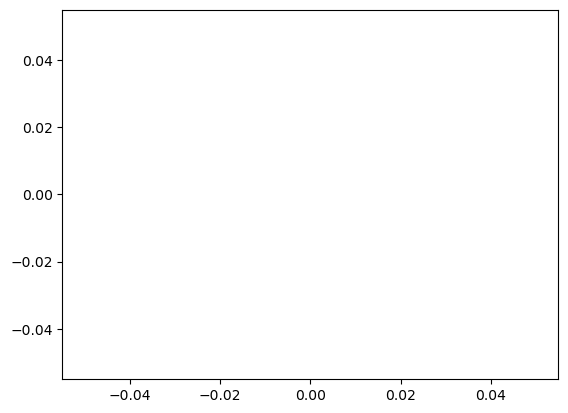

In [16]:
plt.plot(epochs[:, 22])

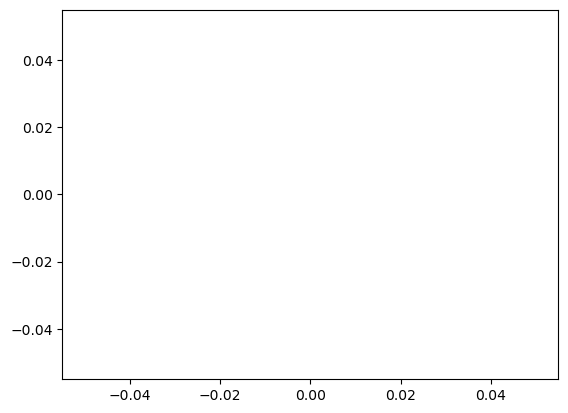

In [15]:
plt.plot(TEPs[0, :, 22])

In [2]:
folder_speed_data = r"..\..\dist_2024_11_13_imp\mulines\src\mulines\data"  # laptop

In [18]:
def redefine_trigger(trigger, bit):
    ttl = np.array(trigger, dtype=np.uint8)
    return ((ttl>>bit) & 0b1).astype(int)

def ms_to_samples(time, Fs=25000):
    return int(time*Fs/1000)

def samples_to_ms(samples, Fs=25000):
    return round(samples*1000/Fs, 2)

def find_idx_events(trigger, parse_trigger=False, bit=1, edge_to_detect='rising'):
    if parse_trigger:
        trigger = redefine_trigger(trigger, bit)
    if edge_to_detect == 'rising':
        return np.where((trigger == 1) & (np.roll(trigger, 1) == 0))[0]  # момент триггера
    elif edge_to_detect == 'falling':
        return np.where((trigger == 0) & (np.roll(trigger, 1) == 1))[0]  # end - start = 25
    else:
        raise ValueError("edge_to_detect должен быть либо 'rising', либо 'falling'.")
    
def cut_epoch(n_epoch, data, idx_events, idx_start=-7500, idx_end=12500):
    idx = idx_events[n_epoch]
    return data[idx+idx_start:idx+idx_end]

In [19]:
def make_baseline_matrix(n_samples, idx1, idx2):
    if not (0 <= idx1 < idx2 <= n_samples):
        raise ValueError("Некорректные индексы. Надо чтобы удовлетворяли условию: 0 <= idx1 < idx2 <= n_samples.")
    
    baseline_length = idx2 - idx1
    B = np.zeros((n_samples, n_samples))
    B[:, idx1:idx2] = 1.0 / baseline_length

    I = np.eye(n_samples)
    
    return I - B

In [20]:
def apply_highpass(data, freq=.5, type='highpass', Fs=25E3):
    sos_butter = signal.butter(2, freq/(Fs/2), btype=type, output='sos')
    return signal.sosfiltfilt(np.ascontiguousarray(sos_butter), data, axis=0)

def apply_notch(data, freq=50, dfreq=.5, Fs=25E3):
    b_notch, a_notch = signal.iirnotch(freq, freq / dfreq, fs=Fs)
    sos_notch = signal.tf2sos(b_notch, a_notch)
    return signal.sosfiltfilt(sos_notch, data, axis=0)

In [21]:
def check_group_delay(Fs, b, a, freq=0, show_plot=False):
    w, gd = signal.group_delay((b, a), fs=Fs)  # gd в сэмплах

    def get_gd_at(freq_hz):
        idx = np.argmin(np.abs(w - freq_hz))
        return {"freq": w[idx], "n_samples": int(gd[idx]), "time": gd[idx]/Fs*1000}

    if show_plot:
        plt.figure(figsize=(7, 2))
        plt.title('Digital filter group delay')
        plt.plot(w, gd)
        plt.ylabel('Group delay [samples]')
        plt.xlabel('Frequency [rad/sample]')
        plt.show()

    return get_gd_at(freq)

# resave file

In [22]:
params = {}
filename = r"..\data\tests\test_008_piu.h5"
filename = r"D:\Resonance\distro-dual\msvc\bin\02_tms_mi_60.h5"
with h5py.File(filename, "r") as h5f:
    for key in h5f['eeg/streamInfo'].keys():
        if key in ['temporary_as_json']:
            params[key] = np.array([json.loads(h5f['eeg/streamInfo'][key].asstr()[:][0])], dtype=object)
        elif key in ['name', 'type', 'uid']:
            params[key] = h5f['eeg/streamInfo'][key].asstr()[()]
        elif key in ['channels', 'samplingRate']:
            params[key] = h5f['eeg/streamInfo'][key][:]
        elif key == 'connections':
            params[key] = h5f['eeg/streamInfo'][key].asstr()[:]

    blocks = h5f['eeg/blocks'][:]
    data = h5f['eeg/data'][:]

Text(0.5, 0, 'idx')

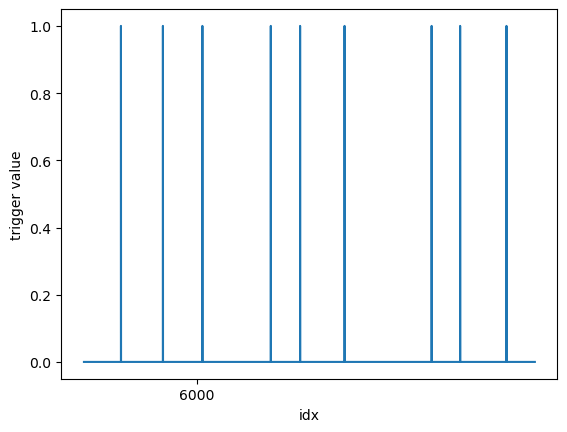

In [23]:
# select desired segment
start, end = 6000, 30000
time_end = int(end * 25000 / 1000)
time_start = int(start * 25000 / 1000)
trigger = redefine_trigger(data[:, -1], 1)
plt.plot(trigger[time_start:time_end]);
step = 25000
plt.xticks(np.arange(time_start, time_end, step *25000/1000), np.arange(start, end, step))
plt.ylabel('trigger value')
plt.xlabel('idx')

In [ ]:
def cut_segment(start, end, blocks, data):
    """
    params:
        - start : время начальной точки в мс
        - end : время конечной точки в мс
    """
    
    def find_nearest_block(ts, time_moment):
        t_first = ts[0]
        for i, t in enumerate(ts):
            if t > t_first + time_moment*1E6:
                return i
        return None

    start_idx = find_nearest_block(blocks["created"], start)
    end_idx = find_nearest_block(blocks["created"], end)
    if start_idx is None or end_idx is None:
        print(f"start time index: {start_idx}; end time index: {end_idx}. Sth is wrong here.")
        return None, None
    
    def calculate_data_idx(block_sizes, block_idx):
        data_idx = 0
        for i in range(block_idx):
            data_idx += block_sizes[i]
        return data_idx
    
    data_start_idx = calculate_data_idx(blocks["samples"], start_idx)
    data_end_idx = calculate_data_idx(blocks["samples"], end_idx)

    # cut segment of data
    data2safe = data[data_start_idx:data_end_idx]
    blocks2safe = blocks[start_idx:end_idx]
    return data2safe, blocks2safe

data2safe, blocks2safe = cut_segment(start, end, blocks, data)
data2safe.shape, blocks2safe.shape

In [ ]:
filename_output = r"..\data\02_tms_mi_60_short.h5"
string_dt = h5py.string_dtype(encoding='utf-8')
with h5py.File(filename_output, "w") as h5f:
    eeg = h5f.create_group('eeg')
    streamInfo = eeg.create_group('streamInfo')
    for key, value in params.items():
        if key == 'temporary_as_json': 
            data = np.array([json.dumps(value[0])], dtype=object)
            streamInfo.create_dataset(key, data=data, dtype=string_dt)
        elif key == 'connections':
            data = value.tolist()
            streamInfo.create_dataset(key, data=data, dtype=string_dt)
        else:
            streamInfo.create_dataset(key, data=value)
    dtype = [('created', '<u8'), ('received', '<u8'), ('samples', '<u4')]
    data_np = np.array(list(blocks2safe), dtype=dtype)
    eeg.create_dataset('blocks', data=data_np, shape=data_np.shape, dtype=dtype)
    eeg.create_dataset('data', data=data2safe)

# check SPEED interpolation and windowizer

In [222]:
signal[:, :64].shape

(600680, 64)

In [210]:
filename = r"D:\Resonance\distro-dual\msvc\mulines\src\mulines\data\whole_dataset_02.h5"
with h5py.File(filename, 'r') as h5f:
    epochs = h5f["epochs"][:]
    raw = h5f['raw_signal'][:]
    interp = h5f['interp_signal'][:]
    high_filt = h5f["high_filt"][:]
    notch_filt = h5f["notch_filt"][:]
    signal = h5f['signal'][:]
    signal_filt = h5f["signal_filt"][:]


In [224]:
np.concatenate([signal[:, :64] * 1E6, np.diff(signal[:, 64:66], axis=1)*1E3], axis=1)

array([[-2.52507806e+10, -3.47707999e+10, -4.01386709e+09, ...,
        -3.07665520e+10, -2.59902337e+10, -1.99363276e+10],
       [-2.52736322e+10, -3.47652823e+10, -4.01874990e+09, ...,
        -3.07580070e+10, -2.59906243e+10, -1.99303706e+10],
       [-2.52603509e+10, -3.47647940e+10, -4.01821279e+09, ...,
        -3.07454582e+10, -2.59816888e+10, -1.99344722e+10],
       ...,
       [-2.53349115e+10, -3.49115714e+10, -4.07094716e+09, ...,
        -3.07816887e+10, -2.60017083e+10, -1.99705073e+10],
       [-2.53223138e+10, -3.49134757e+10, -4.07685537e+09, ...,
        -3.07914055e+10, -2.59882318e+10, -1.99562983e+10],
       [-2.53277337e+10, -3.48990714e+10, -4.08588857e+09, ...,
        -3.07857414e+10, -2.59905267e+10, -1.99568354e+10]])

In [211]:
Fs = 25000
duration = len(raw) / Fs
duration

24.024

In [212]:
filename_origin = r"..\data\02_tms_mi_60_short.h5"
with h5py.File(filename_origin, 'r') as h5f:
    blocks = h5f['eeg/blocks'][:]
raw.shape[0] - interp[blocks["samples"][0]:].shape[0], f"last block duration: {blocks['samples'][-1]}"

(1920, 'last block duration: 1920')

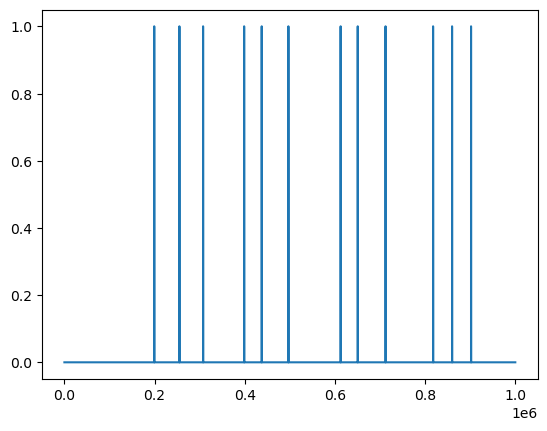

In [213]:
triger = redefine_trigger(raw[:, -1], bit=1)
plt.plot(trigger[:50000*20])

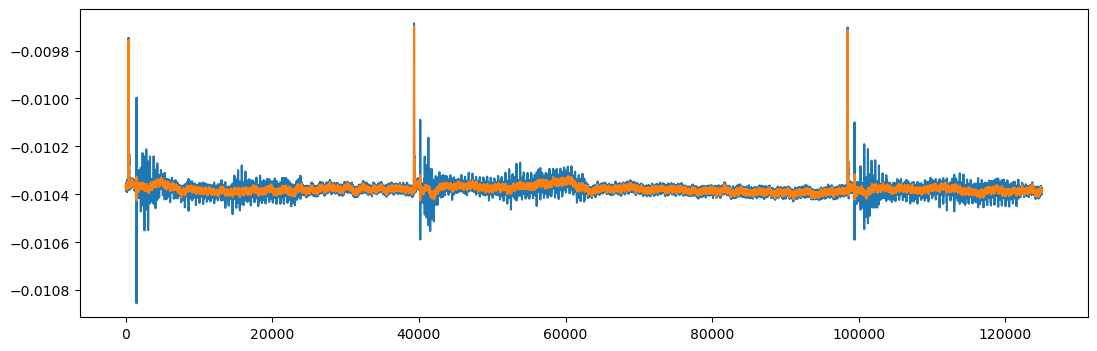

In [215]:
start = 10 * Fs 
end = 15 * Fs
channel = 22
plt.figure(figsize=(13, 4))
# plt.plot(raw[start:end, channel])
# plt.plot(interp[start:end, channel])
# plt.plot(high_filt[start:end, channel])
# plt.plot(notch_filt[start:end, channel])
plt.plot(notch_filt[start:end, channel])
plt.plot(signal_filt[start:end, channel])

In [175]:
a = np.array([[0, 1, 2], [0, 1, 2]])
a.shape, np.sum(a, axis=0), np.sum(a, axis=1)

((2, 3), array([0, 2, 4]), array([3, 3]))

In [204]:
from scipy.signal import butter, sosfilt, sosfilt_zi

freq = 2000
sos_low = butter(2, freq/Fs*2, btype='lowpass', output='sos')
zi = np.repeat(sosfilt_zi(sos_low)[:, :, np.newaxis], 66, axis=2)
zi.shape

(1, 2, 66)

In [205]:
signal_filt, zo = sosfilt(np.ascontiguousarray(sos_low), notch_filt, axis=0, zi=zi)

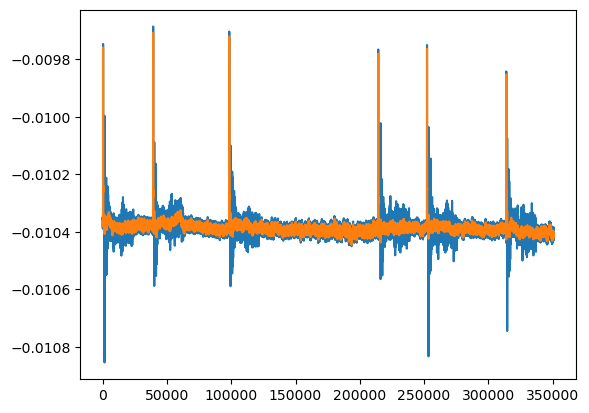

In [208]:
signal_filt[:, channel], signal[:, channel]
plt.plot(notch_filt[start:, channel])
plt.plot(signal_filt[start:, channel])

In [ ]:
filename = r"D:\Resonance\distro-dual\msvc\mulines\src\mulines\data\whole_dataset_02.h5"

with h5py.File(filename, 'r') as h5f:
    raw = h5f['raw_signal'][:]
    interp = h5f['interp_signal'][:]

    TEPs_stream = h5f["TEPs"][:]
    MEPs_stream = h5f["MEPs"][:]

    TEPs_json = [json.loads(data) for data in h5f['TEPs_event'][:]] 
    MEPs_json = [json.loads(data) for data in h5f['MEPs_event'][:]] 
    epochs_json = [json.loads(data) for data in h5f['epochs_event'][:]] 

In [ ]:
filename_origin = r"..\data\02_tms_mi_60_short.h5"
with h5py.File(filename_origin, 'r') as h5f:
    blocks = h5f['eeg/blocks'][:]

In [ ]:
raw.shape[0] - interp[blocks["samples"][0]:].shape[0], f"last block duration: {blocks['samples'][-1]}"

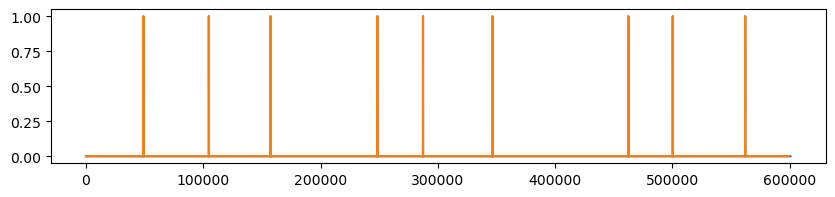

In [61]:
tr_raw = redefine_trigger(raw[:, -1], bit=1)
tr_int = redefine_trigger(interp[:, -1], bit=1)
plt.figure(figsize=(10, 2))
plt.plot(tr_raw)
plt.plot(tr_int[blocks["samples"][0]:]) # without first block

In [62]:
Fs = 5000
art_start, art_end = -0.04, 0.85 # ms
idx_art_start, idx_art_end = ms_to_samples(art_start, Fs), ms_to_samples(art_end, Fs)
window_start, window_end = -100, 300
idx_window_start, idx_window_end = ms_to_samples(window_start, Fs), ms_to_samples(window_end, Fs)
idx_art_start, idx_art_end, idx_window_start, idx_window_end

(0, 4, -500, 1500)

In [64]:
n_events = len(TEPs_json)
n_samples = idx_window_end-idx_window_start
TEPs = TEPs_stream.reshape((n_events, n_samples, 64))

NameError: name 'TEPs_json' is not defined

In [ ]:
baseline_start, baseline_end = -70, -20 # ms
shift = 0 - idx_window_start
M = make_baseline_matrix(n_samples, shift + ms_to_samples(baseline_start, Fs), shift + ms_to_samples(baseline_end, Fs))

In [ ]:
n_epoch, n_channel = 0, 10
plt.figure(figsize=(10, 2))
plt.plot(np.arange(window_start, window_end, 1000/Fs), M @ TEPs[n_epoch, :, n_channel])
plt.axvline(0, color='black')
# plt.ylim(-100, 100)
plt.xlim(-10, 30)

# check filtering

In [6]:
filename = os.path.join(folder_speed_data, "speed_02_tms_mi_60_short.h5")
with h5py.File(filename, 'r') as h5f:
    raw = h5f['raw_signal'][:]
    interp = h5f['interp_signal'][:]

In [7]:
Fs = 25000                              # Hz
art_start, art_end = -0.04, 0.85        # ms
window_start, window_end = -300, 500    # ms

idx_art_start, idx_art_end = ms_to_samples(art_start, Fs), ms_to_samples(art_end, Fs)
idx_window_start, idx_window_end = ms_to_samples(window_start, Fs), ms_to_samples(window_end, Fs)

In [8]:
baseline_start, baseline_end = -70, -20             # ms
n_samples = idx_window_end - idx_window_start
shift = 0 - idx_window_start
M = make_baseline_matrix(n_samples, shift + ms_to_samples(baseline_start, Fs), shift + ms_to_samples(baseline_end, Fs))

In [9]:
trigger = redefine_trigger(interp[:, -1], bit=1)
idx_events = find_idx_events(trigger, edge_to_detect='rising')

In [145]:
cut = lambda x: cut_epoch(4, x, idx_events, idx_window_start, idx_window_end)
cut_by_idx = lambda x, idx: cut_epoch(idx, x, idx_events, idx_window_start, idx_window_end)

In [ ]:
def plot_signal_interactive(data, n_ticks=5, Fs=25000):  
    assert len(data) < 50000, "Input data is too large for interactive plot!"
    fig = go.Figure()
    fig.add_traces(go.Scatter(y=data, mode='lines'))
    fig.update_layout(width=500, height=250, title_font=dict(size=16), font=dict(size=12), 
                        margin=dict(l=5, r=5, t=30, b=10), title={"x": 0.5})
    duration = len(data) * 1000/Fs
    a = int(duration // n_ticks)
    fig.update_xaxes(title="Time [ms]", title_standoff=5, 
                     tickvals=np.arange(len(data))[::25*a], ticktext=np.arange(duration)[::a])
    fig.update_yaxes(title="EEG signal [" + "\u03BC"+"V]", title_standoff=1)

    return fig

def plot_signal(data, n_ticks=5, Fs=25000):  
    plt.figure(figsize=(7, 3))
    plt.plot(data)
    plt.xlabel("Time [ms]")
    plt.ylabel("EEG signal [" + "\u03BC"+"V]")
    duration = len(data) * 1000/Fs
    a = int(duration // n_ticks)
    plt.xticks(np.arange(len(data))[::25*a],np.arange(len(data) * 1000/Fs)[::a] )

In [44]:
def show_spectr(data, Fs, delta_f=1, p_overlap=0.5, fr_min=0, fr_max=100, specific_title=None):
    title = "Power Spectral Density"
    if specific_title is not None:
        title += " (" + specific_title + ")"
    N = Fs//delta_f  # длина окна 
    f, psd = signal.welch(data, fs=Fs, nperseg=N, noverlap=N * p_overlap)
    fig = go.Figure()
    fig.add_traces(go.Scatter(x=f, y=psd, mode="lines"))
    fig.update_layout(title={"text": title, "x": 0.5, "y": 0.99}, 
                      width=500, height=300, title_font=dict(size=16), margin=dict(l=10, r=10, t=20, b=10))
    fig.update_xaxes(title="Frequency [Hz]", title_standoff=1,  title_font=dict(size=14), tickfont=dict(size=12), showgrid=True, range=[fr_min, fr_max])
    fig.update_yaxes(title="Power spectral density [µV²/Hz]",  title_standoff=1,  title_font=dict(size=14), tickfont=dict(size=12), showgrid=True)

    return fig

def plot_filtered(data, filt, M, show_start=-10, show_end=100, ymax=100, ymin=-100, shift=0, label="filtered"):
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=M[shift:, shift:] @ data[shift:], mode='lines', name='raw signal'))
    fig.add_trace(go.Scatter(y=M @ filt, mode='lines', name=label))

    fig.update_layout(width=500, height=250, title_font=dict(size=16), font=dict(size=12), 
                      margin=dict(l=5, r=5, t=30, b=10), title={"x": 0.5})

    idx_show = [-(idx_window_start)+ms_to_samples(show_start, Fs), -(idx_window_start)+ms_to_samples(show_end, Fs)]

    a = 10
    fig.update_xaxes(title="Time [ms]", title_standoff=5,
                     tickvals=np.arange(len(data))[::25*a], ticktext=np.arange(window_start, window_end)[::a],
                     range=idx_show)
    fig.update_yaxes(title="EEG signal [" + "\u03BC"+"V]", title_standoff=1,
                     
                     range=[ymin, ymax])
    fig.show()

In [ ]:
def plot_epoch(data, M=None, show_start=-10, show_end=100, ymax=100, ymin=-100, shift=0, Fs = 25000, 
               window_start=-300, 
               name='karasi', 
               ylabel="EEG signal [" + "\u03BC"+"V]"):
    fig = go.Figure()
    data2plot = M[shift:, shift:] @ data[shift:] if M is not None else data[shift:]

    idx_window_start = ms_to_samples(window_start, Fs=Fs)

    t = np.arange(0, data2plot.shape[0], Fs ) 
    fig.add_trace(go.Scatter(x=t, y=data2plot, mode='lines', name=name))
    fig.add_vline(x=-(idx_window_start), 
    
    line_width=1,
    line_dash="dot",           # варианты: "solid", "dash", "dot", ...
    line_color="black",
    annotation_text="TMS piu",    # подпись (опционально)
    annotation_position="top right"
    )

    fig.update_layout(width=500, height=250, title_font=dict(size=16), font=dict(size=12), 
                      margin=dict(l=5, r=5, t=30, b=10), title={"x": 0.5})

    idx_show = [-(idx_window_start)+ms_to_samples(show_start, Fs), -(idx_window_start)+ms_to_samples(show_end, Fs)]

    a = 10
    s = Fs // 1000
    fig.update_xaxes(title="Time [ms]", title_standoff=5,
                     tickvals=np.arange(len(data))[::s*a], ticktext=np.arange(window_start, window_end)[::a],
                     range=idx_show)
    fig.update_yaxes(title=ylabel, title_standoff=1, range=[ymin, ymax])
    return fig

def combine_figures(fig1, fig2, name1, name2):
    fig1.data[0].name = name1
    for trace in fig2.data:
        trace.name = name2
        fig1.add_trace(trace)
    return fig1

## EEG

In [12]:
n_channel = 9 # C3
eeg_channel = interp[:, n_channel] * 1E6

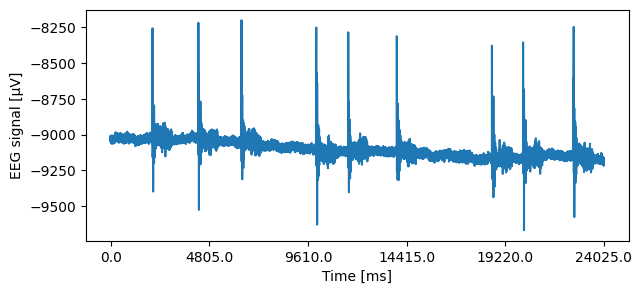

In [45]:
# plot_signal_interactive(eeg_channel)
plot_signal(eeg_channel)

In [46]:
show_spectr(eeg_channel, Fs, specific_title='C3 channel')

### notch filter 50 Hz

In [28]:
# notch filter 
b_notch, a_notch = signal.iirnotch(50, 50 / 1, fs=25000)
group_delay = check_group_delay(Fs, b_notch, a_notch, freq=0, show_plot=False)
print(f'freq={group_delay["freq"]:.0f} Hz, n_samples={group_delay["n_samples"]:.0f}, time={group_delay["time"]:.3f} ms')
sos_notch = signal.tf2sos(b_notch, a_notch)
filtered = signal.sosfiltfilt(sos_notch, eeg_channel)

plot_filtered(cut(eeg_channel), cut(filtered), M, shift=group_delay["n_samples"])

freq=0 Hz, n_samples=1, time=0.064 ms


In [29]:
fig1 = show_spectr(filtered, Fs, specific_title='notch=50 Hz', delta_f=0.5)
fig1.data[0].name = 'filtered'
fig2 = show_spectr(eeg_channel, Fs, delta_f=0.5)
for trace in fig2.data:
    trace.name = "raw data"
    fig1.add_trace(trace)

fig1

### highpass filter

In [35]:
# highpass filter
lowFreq = 1
sos_butter = signal.butter(2, lowFreq/(Fs/2), btype="highpass", output='sos')
b, a = signal.sos2tf(sos_butter)
group_delay = check_group_delay(Fs, b, a, freq=lowFreq, show_plot=False)
print(f'freq={group_delay["freq"]:.0f} Hz, n_samples={group_delay["n_samples"]:.0f}, time={group_delay["time"]:.3f} ms')
filtered = signal.sosfiltfilt(np.ascontiguousarray(sos_butter), eeg_channel)
plot_filtered(cut(eeg_channel), cut(filtered), M, shift=group_delay["n_samples"])

C:\Users\hodor\AppData\Local\Temp\ipykernel_15248\525288219.py:2: UserWarning:

The filter's denominator is extremely small at frequencies [0.000], around which a singularity may be present



freq=0 Hz, n_samples=0, time=0.000 ms


In [36]:
dfreq = 1
fig1 = show_spectr(filtered, Fs, specific_title=f'highpass {lowFreq}', delta_f=dfreq, fr_max=40)
fig1.data[0].name = 'filtered'
fig2 = show_spectr(eeg_channel, Fs, delta_f=dfreq)
for trace in fig2.data:
    trace.name = "raw data"
    fig1.add_trace(trace)

fig1

### median filter

In [37]:
k = 21
median_filter = lambda x: x - signal.medfilt(x, kernel_size=k)

In [38]:
filtered = median_filter(eeg_channel)
plot_filtered(cut(eeg_channel), cut(filtered), M, shift=0)

In [40]:
dfreq = 1
fig1 = show_spectr(filtered, Fs, specific_title=f'median filter', delta_f=dfreq, fr_max=100)
fig1.data[0].name = 'filtered'
fig2 = show_spectr(eeg_channel, Fs, delta_f=dfreq)
for trace in fig2.data:
    trace.name = "raw data"
    fig1.add_trace(trace)

fig1

## EMG

In [184]:
ch65 =  interp[:, 64] * 1E3
ch66 =  interp[:, 65] * 1E3
emg_raw_channel = np.diff(interp[:, [64, 65]] * 1E3, axis=1).squeeze()
filtered = apply_highpass(emg_raw_channel)
t = np.arange(emg_raw_channel.shape[0]) / Fs   # время в секундах

In [185]:
emg_channel = apply_highpass(np.diff(interp[:, [64, 65]] * 1E3, axis=1).squeeze(), freq=1)
t = np.arange(emg_channel.shape[0]) / Fs   # время в секундах

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
fig.suptitle("EMG", fontsize=16, y=0.9)

axes[0].plot(t, ch65, color='tab:blue')
axes[0].set_ylabel("signal [mV]")
axes[0].set_title("channel = 65", loc='left')

axes[1].plot(t, ch66, color='tab:orange')
axes[1].set_ylabel("signal [mV]")
axes[1].set_title("channel = 66", loc='left')

axes[2].plot(t, emg_channel, color='tab:green')
axes[2].set_ylabel("signal [mV]")
axes[2].set_xlabel("time [s]")
axes[2].set_title("ch66 - ch65", loc='left')

# Настройки внешнего вида
plt.tight_layout(rect=[0, 0, 1, 0.96])  # чтобы не налегал suptitle
plt.show()

## epochs analysis

In [240]:
filtered = apply_highpass(interp[:, :-1], type='highpass', freq=1)
filtered = apply_notch(filtered)

In [242]:
N_eeg_ch = 64  # количество ЭЭГ-каналов
EMG_ch = [N_eeg_ch+1, N_eeg_ch]
data = np.concatenate([filtered[:, :N_eeg_ch] * 1E6, np.diff(filtered[:, EMG_ch], axis=1)*1E3], axis=1)

In [247]:
data_2500 = apply_highpass(data, type="lowpass", freq=2500)
data_2000 = apply_highpass(data, type="lowpass", freq=2000)

In [252]:
epochs = np.array([cut_by_idx(data, idx) for idx in range(len(idx_events))])    # [n_epochs, n_samples, n_channels] n_channels = N_eeg + emg
epochs_2000 = np.array([cut_by_idx(data_2000, idx) for idx in range(len(idx_events))])    
epochs_2500 = np.array([cut_by_idx(data_2500, idx) for idx in range(len(idx_events))])    

In [275]:
n_epoch = 0
n_channel = 1
fig1 = plot_epoch(epochs[n_epoch, :, n_channel], M=None, show_start=-10, show_end=100, ymax=100, ymin=-100, shift=0, 
           name=f'epoch #{n_epoch}', ylabel="EMG signal [mV]")
fig2 = plot_epoch(epochs_2500[n_epoch, :, n_channel], M=None, show_start=-10, show_end=100, ymax=100, ymin=-100, shift=0, 
           name=f'epoch #{n_epoch}', ylabel="EMG signal [mV]")
combine_figures(fig1, fig2, "raw_data", "filtered")

In [276]:
decim = Fs // 5000
downsample = lambda x: x[::decim]

In [277]:
fig1 = plot_epoch(epochs[n_epoch, :, n_channel], M=None, show_start=-10, show_end=100, ymax=100, ymin=-100, shift=0, 
           name=f'epoch #{n_epoch}', ylabel="EMG signal [mV]")
fig2 = plot_epoch(downsample(epochs[n_epoch, :, n_channel]), M=None, show_start=-10, show_end=100, ymax=100, ymin=-100, shift=0, 
                  Fs=5000, 
           name=f'epoch #{n_epoch}', ylabel="EMG signal [mV]")
combine_figures(fig1, fig2, "raw_data", "filtered")

In [281]:
fig1.data

(Scatter({
     'mode': 'lines',
     'name': 'raw_data',
     'x': array([    0,     1,     2, ..., 19997, 19998, 19999], shape=(20000,)),
     'y': array([-4.23008014,  8.19487557,  5.04426245, ...,  4.57702275,  3.63259838,
                  3.17708743], shape=(20000,))
 }),
 Scatter({
     'mode': 'lines',
     'name': 'filtered',
     'x': array([   0,    1,    2, ..., 3997, 3998, 3999], shape=(4000,)),
     'y': array([ -4.23008014,   6.43584356,   6.17893096, ..., -10.45484282,
                   2.46587291,   0.2177882 ], shape=(4000,))
 }))

In [279]:
fig1

In [198]:
n_epoch = 0
fig1 = plot_epoch(emg_epochs[n_epoch], M=None, show_start=-10, show_end=100, ymax=1, ymin=-1, shift=0, 
           name=f'epoch #{n_epoch}', ylabel="EMG signal [mV]")
fig2 = plot_epoch(filt_epochs[n_epoch], M=None, show_start=-10, show_end=100, ymax=1, ymin=-1, shift=0, 
           name=f'epoch #{n_epoch}', ylabel="EMG signal [mV]")
combine_figures(fig1, fig2, "raw_data", "filtered")

In [223]:
eeg_epochs = np.array([cut_by_idx(eeg_channel, idx) for idx in range(len(idx_events))])
eeg_notch = np.array([apply_notch(epoch) for epoch in eeg_epochs])
eeg_1hz = np.array([apply_highpass(epoch) for epoch in eeg_epochs])
eeg_250Hz = np.array([apply_highpass(epoch, type="lowpass", freq=500) for epoch in eeg_notch])

In [224]:
n_epoch = 0
fig1 = plot_epoch(eeg_notch[n_epoch], M=M, show_start=-10, show_end=100, ymax=100, ymin=-100, shift=0, 
           name=f'epoch #{n_epoch}', ylabel="EMG signal [mV]")
fig2 = plot_epoch(eeg_250Hz[n_epoch], M=M, show_start=-10, show_end=100, ymax=100, ymin=-100, shift=0, 
           name=f'epoch #{n_epoch}', ylabel="EMG signal [mV]")
combine_figures(fig1, fig2, "raw_data", "filtered")

In [ ]:
epochs = np.array([interp[idx+idx_window_start:idx+idx_window_end, :] for idx in idx_events]) * 1E6
epochs.shape    # [n_epoch, n_sample, n_channel]

In [ ]:
n_epoch = 4
n_channel = 9  # C3
data = epochs[n_epoch, :, n_channel]    # [n_sample, ]

In [ ]:
# lowpass filter
freq = 1250
sos_butter = signal.butter(2, freq/(Fs/2), btype="lowpass", output='sos')
filt = signal.sosfiltfilt(np.ascontiguousarray(sos_butter), data)
plot_filtered(data, filt, M, show_start=-10, show_end=100, ymax=200, shift=0, label="highpass filter: 250 Hz, shifted=23 samples")

In [ ]:
# highpass filter
freq = 250
sos_butter = signal.butter(2, freq/(Fs/2), btype="lowpass", output='sos')
filt = signal.sosfiltfilt(np.ascontiguousarray(sos_butter), data)
plot_filtered(data, filt, M, show_start=-10, show_end=100, ymax=500, ymin=-100, shift=56, label="highpass filter: 100 Hz, shifted=23 samples")

In [ ]:
check_group_delay(Fs=25000, freq=250, type="lowpass", show_plot=False)

In [ ]:
plt.figure(figsize=(7, 2))
f, psd = signal.periodogram(data, fs=25E3, scaling='density', nfft=10000)
plt.plot(psd)
# f, psd = signal.periodogram(filt, fs=25E3, scaling='density', nfft=1000)
# plt.plot(psd)
# plt.xlim(0, 20)
plt.xlabel("Hz")
plt.title("PSD")

In [12]:
filename = os.path.join(folder_speed_data, "new_02_tms_mi_60_short.h5")
string_dt = h5py.string_dtype(encoding='utf-8')
with h5py.File(filename, 'r') as h5f:
    # high_filt = h5f["high_filt"][:]
    # notch_filt = h5f['notch_filt'][:]
    interp_signal = h5f["interp_signal"][:]
    # raw_signal = h5f["raw_signal"][:]
    
    signal = h5f['signal'][:]
    signal_filt = h5f['signal_filt'][:]
    
    epochs = h5f['epochs'][:]

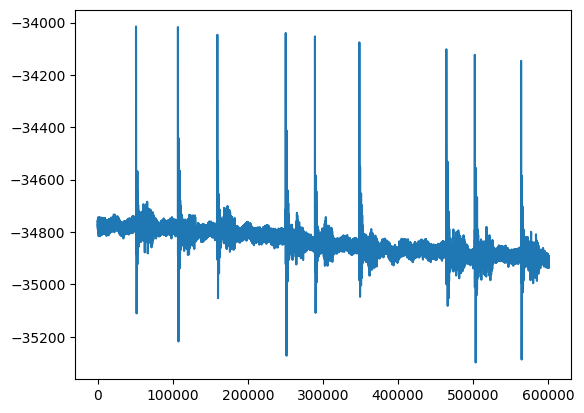

In [13]:
plt.plot(signal[:, 1])

In [36]:
sos_high = signal.butter(2, 1/25000*2, btype='highpass', output='sos')
high_filt_off = signal.sosfilt(np.ascontiguousarray(sos_high), interp_signal[:, 1])

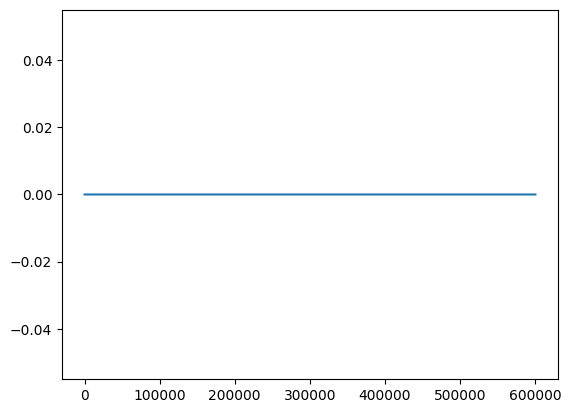

In [4]:
plt.plot(high_filt[:, 1])
# plt.plot(high_filt_off)

In [44]:
notch_width = 1
Q = 50 / notch_width
b_notch, a_notch = signal.iirnotch(50, Q, fs=25000)
sos_notch = signal.tf2sos(b_notch, a_notch)
notch_filt_off = signal.sosfilt(np.ascontiguousarray(sos_notch), high_filt[:, 1])

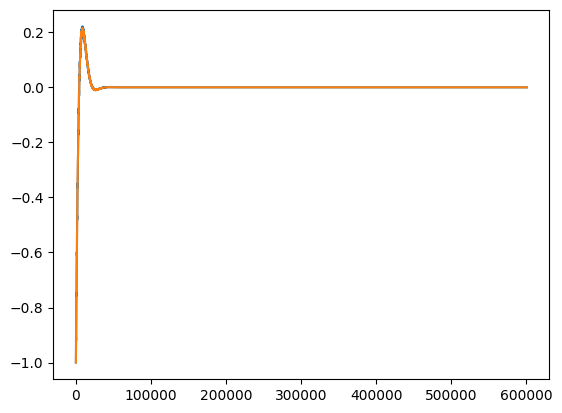

In [ ]:
plt.plot(notch_filt[:, 1])
plt.plot(notch_filt_off)

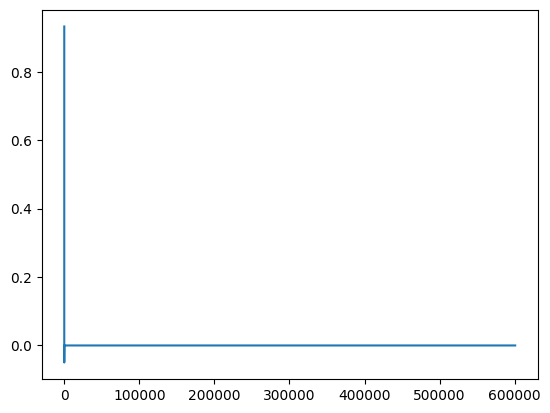

In [8]:
plt.plot(signal_filt[:, 1])

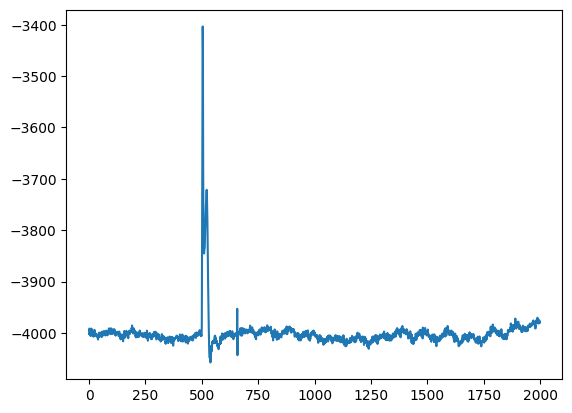

In [15]:
plt.plot(epochs[:2000, 2])

In [77]:
epochs

array([[5.e-324, 5.e-324, 5.e-324, ..., 5.e-324, 5.e-324, 5.e-324],
       [5.e-324, 5.e-324, 5.e-324, ..., 5.e-324, 5.e-324, 5.e-324],
       [5.e-324, 5.e-324, 5.e-324, ..., 5.e-324, 5.e-324, 5.e-324],
       ...,
       [5.e-324, 5.e-324, 5.e-324, ..., 5.e-324, 5.e-324, 5.e-324],
       [5.e-324, 5.e-324, 5.e-324, ..., 5.e-324, 5.e-324, 5.e-324],
       [5.e-324, 5.e-324, 5.e-324, ..., 5.e-324, 5.e-324, 5.e-324]],
      shape=(18000, 65))

In [67]:
data = signal_filt[:, :]

In [68]:
downsample = lambda x: x[::5]
downsample(data)

array([[-6.74254048e+004, -6.74254048e+004, -6.74254048e+004, ...,
        -6.74254048e+004, -6.74254048e+004,  9.32544726e-001],
       [-1.02204634e+006, -1.02204634e+006, -1.02204634e+006, ...,
        -1.02204634e+006, -1.02204634e+006, -2.47597753e-002],
       [-1.00015218e+006, -1.00015218e+006, -1.00015218e+006, ...,
        -1.00015218e+006, -1.00015218e+006, -7.28111066e-003],
       ...,
       [ 6.57386827e-029,  6.57386827e-029,  6.57386827e-029, ...,
         6.57386827e-029,  6.57386827e-029,  4.94065646e-324],
       [ 6.50773502e-029,  6.50773502e-029,  6.50773502e-029, ...,
         6.50773502e-029,  6.50773502e-029,  4.94065646e-324],
       [ 6.41601789e-029,  6.41601789e-029,  6.41601789e-029, ...,
         6.41601789e-029,  6.41601789e-029,  4.94065646e-324]],
      shape=(120136, 65))

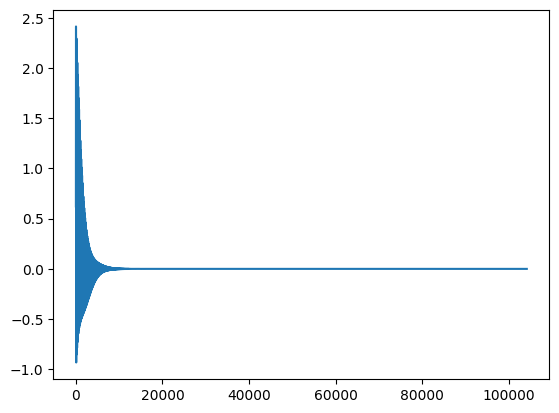

In [73]:
plt.plot(downsample(data[80000:, 1]))